
**Transfer Learning VGG 16 and VGG 19 using Keras**

In [1]:
# import the libraries

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to your zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Pneumonia_Detection_VIT/data_chestXray.zip'

In [4]:
# Destination folder where you want to extract the files
extracted_folder_path = '/content/data_chestXray'

In [5]:
# Check if the extracted folder already exists, if not, create it
if not os.path.exists(extracted_folder_path):
    os.makedirs(extracted_folder_path)

In [6]:
# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print("Extraction complete.")

Extraction complete.


In [7]:

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/data_chestXray/data_chestXray/train'
valid_path = '/content/data_chestXray/data_chestXray/test'

In [8]:

# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [9]:

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [11]:
  # useful for getting number of output classes
folders = glob('/content/data_chestXray/data_chestXray/train/*')

In [12]:

# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [13]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:

# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/data_chestXray/data_chestXray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [18]:
test_set = test_datagen.flow_from_directory('/content/data_chestXray/data_chestXray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [19]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-19-6ec5a35725ca>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 125s 709ms/step - loss: 0.2567 - accuracy: 0.9145 - val_loss: 0.2224 - val_accuracy: 0.9231
Epoch 2/5
163/163 [==============================] - 108s 665ms/step - loss: 0.1062 - accuracy: 0.9599 - val_loss: 0.2547 - val_accuracy: 0.9135
Epoch 3/5
163/163 [==============================] - 109s 668ms/step - loss: 0.0893 - accuracy: 0.9657 - val_loss: 0.3289 - val_accuracy: 0.8942
Epoch 4/5
163/163 [==============================] - 108s 662ms/step - loss: 0.1266 - accuracy: 0.9559 - val_loss: 0.3120 - val_accuracy: 0.9151
Epoch 5/5
163/163 [==============================] - 108s 663ms/step - loss: 0.0714 - accuracy: 0.9730 - val_loss: 0.3331 - val_accuracy: 0.9054


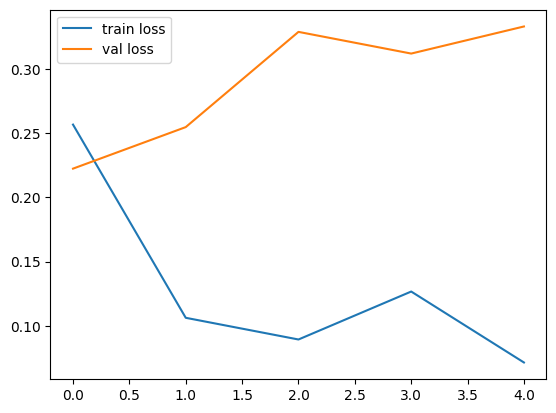

KeyError: 'acc'

<Figure size 640x480 with 0 Axes>

In [20]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [21]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Similary you can use the same template for Vgg 19, Resnet50, Mobilenet. All you have to import the library. Below are the examples

from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3

**Validation**

In [33]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = load_model('model_vgg16.h5')

# Load and preprocess the image
# img_path = '/content/data_chestXray/data_chestXray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'
img_path = '/content/data_chestXray/data_chestXray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension
x = preprocess_input(x)

# Predict classes
classes = model.predict(x)

print(classes)

1/1 [==============================] - 0s 135ms/step
[[0.9950831  0.00491688]]
